
- Ppr - Distributed Representation of words and phrases and their compositionality

- Original SKipgram has expensive softmax operation that deals with all the vocabulary in the denominator of softmax. This is really expensive when the vocabulary is huge.

```
Q = complexity = C * (1 * D + D * log(V)) # Skipgram
Q = complexity = N * D +  D * log(V) # CBOW where N represents the input context words (i/p -> emb projection layer -> output layer)
```

where 1 * D represents the dimension of input(center word) to embedding weight layer, log(V) represents the logartihm of whole vocab and D * log(V) represents the dimension of embedding to linear output layer weight layer. As the skip gram takes the center word and predcicts the context words, we have this operation for all the context words. Hence we are multiplying by C which represents the context words

### The Problem:
In Skip-Gram, for each `(center, context)` pair, we try to predict the correct context word from **all words in the vocabulary**.  
If your vocab has 50,000 words, this becomes **very slow and expensive**.

---

### The Idea of Negative Sampling:
Instead of predicting over the *whole vocabulary*, we:

1. **Keep the real (center, context) pair** — this is the **positive sample**.
2. **Randomly sample a few "wrong" context words** (not actual neighbors) — these are **negative samples**.
3. Train the model to(using softmax):
   - Predict **high probability** for positive pairs.
   - Predict **low probability** for negative pairs.

    Note: Soft part in softmax tries to decrease the value of dissimilar words(denominator) and max part tries to amplify the value fo similar words(numerator)
---

### Think of it like you're teaching the model:
> "This word goes well with this one (positive), and **these few don’t** (negatives). Learn to tell the difference."

---

### Technically:
It changes the loss function from **softmax over the vocab(multinomial classification)** to a simpler **binary classification**:
- Label = 1 neighbors (center, context)
- Label = 0 non-neighbors (center, random word)
- We change the softmax to sigmoid
- Essentially now the objective of skipgram model is changed from "predicting the neighborhood words" to "is words are neighbors"

This makes training **much faster and still effective**.

In this, the non-negihborhood words are subsampled as negative samples and only consider losses of true context words(positive samples) for the given input target word and backpropagated to deal with expensive softmax operation of the whole vocab.We call it negative sampling, as for a binary classifier we also need samples for negative class along with positive class samples.

# Objective of Negative sampling skipgram

Maximizing the likelihood of context words given center word(softmax) -> Maximizing the likelihood of positive samples while minimizing the neighborhood of k negative samples(sigmoid)

\begin{equation}
log(P(w_{t+j} | w_t)) -> log(σ(u_o^T v_c)) + \sum_{k=1}^K \mathbb{E}_{w_i} \sim P_n(w)\ log(\sigma(-u_k^T v_c))
\end{equation}

The k negative samples are sampled from a noise distribution P(w) which is essentially the normalized monogram distribution raised to the power of $\alpha$ where $\alpha$ is a hyperparameter.

**frequent words** (like “the”, “and”, “is”) are a key issue in word2vec, especially for negative sampling.

---

### Problem with Frequent Words in word2vec negative sampling:
Frequent words:
- Appear **everywhere**, but carry **little meaning**.
- Get sampled a lot as **negatives**, which can dominate training and mess with quality.

---

### The Fixes:

#### 1. **Subsampling frequent words** (during data prep):
Word2Vec **randomly discards** very common words (like “the”) during training.

> It uses a probability:
> \begin{equation}
P(w) = 1 - \sqrt{\frac{t}{f(w)}}
\end{equation}

- f(w) is the frequency of word w
- t is a small threshold (e.g., \(10^{-5}\))

** This keeps rare words, drops overused ones.**

---

#### 2. **Smarter negative sampling**:

> This means: **frequent words are still more likely**, but not too dominant.
When picking negative words:
- Don't pick them uniformly.
- Sample based on their frequency raised to the **¾ power** (Zipf’s law correction):

### Normalized monogram distribution

In the paper, authors used normalized monogram distribution for selecting the negative samples.

\begin{equation}
P(w) = \frac{U(w)^{\alpha}}{Z}
\end{equation}

U(w): the raw unigram frequency of word w (how often it appears in the corpus) = freq(w) / total words.
α: the smoothing exponent (usually 0.75 - scales up the u(w)).
Z: a normalization constant, which ensures that all probabilities sum to 1 where
\begin{equation}
Z= \sum_{w∈V} U(w)^\alpha
\end{equation}

It's just the total over all vocab words after applying the exponent. In paper, authors set Z to a small constant 0.001

### Unigram Distribution
In paper, authors suggested $\alpha = \frac{3}{4}$ has the effect of smoothing the unigram distribution and gave the best results.

\begin{equation}
P(w) = \frac{U(w)^{\frac{3}{4}}}{Z}
\end{equation}

---

- Subsampling reduces the **noise** of very common words.
- ¾-power negative sampling gives a **balanced training signal**.

### Loss

\begin{equation}
J_{neg-sample}(v_c, o, U) = -\ log(σ(u_o^T v_c)) - \sum_{k=1}^K log(\sigma(-u_k^T v_c))
\end{equation}




In [60]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time

In [61]:
# Prepare data
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
                 "dog cat animal", "cat animal dog", "cat dog animal"]
corpus = [doc.split(" ") for doc in corpus]

# flatten and generate vocab
flatten = lambda c: [w for doc in c for w in doc]
vocab = list(set(flatten(corpus)))
vocab.append("<UNK>")

# Generate idxs
word2idx = {word:idx for idx, word in enumerate(vocab)}
idx2word = {idx:word for idx, word in enumerate(vocab)}

In [62]:
# Generate target - context pairs (positive samples)
def generate_target_context_pairs(corpus, window_size=1):
    target_context_pairs = []
    tokens = flatten(corpus)
    for i in range(window_size, len(tokens)-window_size):
        center_word = tokens[i]
        ctx_words = tokens[i-window_size:i+window_size]
        # ctx_words = tokens[i-window_size:i] + tokens[i+1:i+window_size+1]
        ctx_words.remove(center_word)
        for ctx in ctx_words:
            target_context_pairs.append((word2idx.get(center_word, word2idx["<UNK>"]), word2idx.get(ctx, word2idx["<UNK>"])))

    return target_context_pairs

In [63]:
from collections import Counter
word_count = Counter(flatten(corpus))
word_count

Counter({'apple': 3, 'banana': 3, 'fruit': 3, 'dog': 3, 'cat': 3, 'animal': 3})

In [64]:
num_total_words = sum(c for w, c in word_count.items())
num_total_words

18

In [92]:
vocab

['cat', 'apple', 'dog', 'fruit', 'banana', 'animal', '<UNK>']

In [65]:
unigram_table = []
z = 0.001

for w in vocab:
    p = int(((word_count[w] / num_total_words)**0.75)/z)
    unigram_table.extend([w] * p)

print(unigram_table)
Counter(unigram_table)

['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat'

Counter({'cat': 260,
         'apple': 260,
         'dog': 260,
         'fruit': 260,
         'banana': 260,
         'animal': 260})

In [66]:
neg = np.random.choice(unigram_table)
neg

np.str_('animal')

In [67]:
word2idx[neg]

5

In [88]:
def prepare_sequence(sequence, word2idx):
    idxs = list(map(lambda w: word2idx[w] if word2idx.get(w) is not None else word2idx["<UNK>"], sequence))
    return torch.LongTensor([idxs])

In [83]:
# Generate Negative samples
def generate_negative_samples(targets, unigram_table, k=5):
    # for each positive sample in the batch, we create k negative samples
    batch_size = targets.size(0)
    negative_samples = []
    for i in range(batch_size):
        k_samples = []
        target_idx = targets[i][0].item()
        while len(k_samples) < k:  # num of sampling
            neg = np.random.choice(unigram_table)
            if word2idx[neg] == target_idx:
                continue
            k_samples.append(neg)
        negative_samples.append(prepare_sequence(k_samples, word2idx).view(1, -1))
    return torch.cat(negative_samples)

In [84]:
# Model
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, voc_size, embed_size) -> None:
        super().__init__()
        self.embedding_in = nn.Embedding(voc_size, embed_size) # center embedding
        self.embedding_out = nn.Embedding(voc_size, embed_size) # ctx embedding
        self.log_sigmoid = nn.LogSigmoid()

    def forward(self, center_words, context_words, negative_samples):
        center_embeddings = self.embedding_in(center_words)                                         # (bs, 1, embed_size)
        ctx_embeddings = self.embedding_out(context_words)                                          # (bs, 1, embed_size)
        negative_embeddings = self.embedding_out(negative_samples)                                  # (bs, k, embed_size)
        positive_score = ctx_embeddings.bmm(center_embeddings.transpose(1, 2)).squeeze(2)           # (bs, 1, embed_size), (bs, embed_size, 1) -> (bs, 1, 1) -> (bs, 1)
        negative_score = -negative_embeddings.bmm(center_embeddings.transpose(1, 2)).squeeze(2)     # (bs, k, embed_size), (bs, embed_size, 1) -> (bs, k, 1) -> (bs, k)
        loss = self.log_sigmoid(positive_score) + torch.sum(self.log_sigmoid(negative_score), 1)
        return -torch.mean(loss)

    def prediction(self, inputs):
        embeds = self.embedding_in(inputs)
        return embeds


In [95]:
# Hyperparameters
epochs = 10000
bs = 2
k = 10
lr = 1e-2
window_size = 1
embed_size = 2

In [96]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [97]:
# Training
voc_size = len(vocab)
target_context_pairs = generate_target_context_pairs(corpus, window_size)
data = torch.LongTensor(target_context_pairs)  # torch.Size([2, 16])
X = data[:, 0]   # torch.Size([16])
Y = data[:, 1]   # torch.Size([16])

model = SkipGramNegativeSampling(voc_size, embed_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training Loop
for epoch in range(epochs):
    start = time.time()
    perm = torch.randperm(n=len(X))
    X_train = X[perm]
    Y_train = Y[perm]
    for i in range(0, len(X_train), bs):
        input_ctr_batch = X_train[i:i+bs].reshape(-1, 1)     # (bs, 1)
        true_ctx_batch = Y_train[i:i+bs].reshape(-1, 1)      # (bs, 1)
        negative_batch = generate_negative_samples(true_ctx_batch, unigram_table, k)   # (bs, k)
        optimizer.zero_grad()
        loss = model(input_ctr_batch, true_ctx_batch, negative_batch)
        loss.backward()
        optimizer.step()

    end = time.time()
    epoch_mins, epoch_secs = epoch_time(start, end)
    if (epoch + 1) % 1000 == 0:
            print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")



Epoch: 1000 | cost: 2.901998 | time: 0m 0s
Epoch: 2000 | cost: 3.229792 | time: 0m 0s
Epoch: 3000 | cost: 2.217482 | time: 0m 0s
Epoch: 4000 | cost: 2.259561 | time: 0m 0s
Epoch: 5000 | cost: 0.877680 | time: 0m 0s
Epoch: 6000 | cost: 2.805129 | time: 0m 0s
Epoch: 7000 | cost: 1.327579 | time: 0m 0s
Epoch: 8000 | cost: 3.390716 | time: 0m 0s
Epoch: 9000 | cost: 1.892427 | time: 0m 0s
Epoch: 10000 | cost: 2.916023 | time: 0m 0s


In [98]:
# Plotting
#get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2idx[word]])
    embed_ctr = model.embedding_in(id_tensor)
    embed_ctx = model.embedding_out(id_tensor)
    word_embed = (embed_ctr + embed_ctx) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()
    return x, y

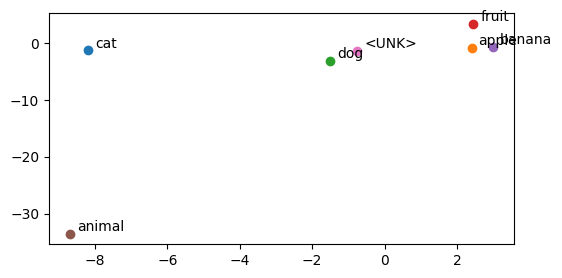

In [99]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [132]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

print(f"cat vs. fruit: ", cos_sim(get_embed("cat"), get_embed("fruit")))
print(f"cat vs. animal: ", cos_sim(get_embed("cat"), get_embed("animal")))
print(f"cat vs. cat: ", cos_sim(get_embed("cat"), get_embed("cat")))

cat vs. fruit:  -0.20431112170076685
cat vs. animal:  0.4034859501457187
cat vs. cat:  1.0000000000000002


Epoch:  1000 | Loss:  2.166
Epoch:  2000 | Loss:  2.086
Epoch:  3000 | Loss:  2.032
Epoch:  4000 | Loss:  1.948
Epoch:  5000 | Loss:  2.425


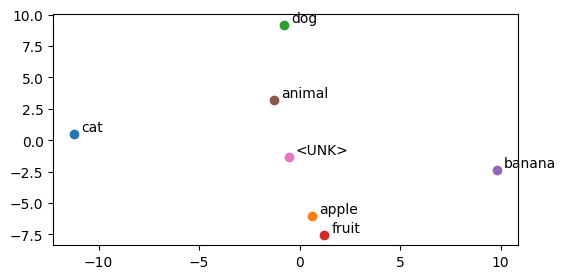

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time

# Prepare data
corpus = ["apple banana fruit",
          "banana apple fruit",
          "banana fruit apple",
          "dog cat animal",
          "cat animal dog",
          "cat dog animal"]
corpus = [doc.split(" ") for doc in corpus]

# flatten and generate vocab
flatten = lambda c: [w for doc in c for w in doc]
vocab = list(set(flatten(corpus)))
vocab.append("<UNK>")

# Generate idxs
word2idx = {word:idx for idx, word in enumerate(vocab)}
idx2word = {idx:word for idx, word in enumerate(vocab)}

# Generate target - context pairs (positive samples)
def generate_target_context_pairs(corpus, window_size=1):
    target_context_pairs = []
    tokens = flatten(corpus)
    for i in range(window_size, len(tokens)-window_size):
        center_word = tokens[i]
        ctx_words = tokens[i-window_size:i+window_size]
        # ctx_words = tokens[i-window_size:i] + tokens[i+1:i+window_size+1]
        ctx_words.remove(center_word)
        for ctx in ctx_words:
            target_context_pairs.append((word2idx.get(center_word, word2idx["<UNK>"]), word2idx.get(ctx, word2idx["<UNK>"])))
    return target_context_pairs

def generate_unigram_table(corpus, alpha=0.75, table_size=1000):
    unigram_table = []
    tokens = flatten(corpus)
    word_counts = Counter(tokens)
    vocab = list(word_counts.keys())
    freq_alpha = []
    for w in vocab:
        raw_freq = (word_counts[w])**alpha  # raw freq instead of relative freq
        freq_alpha.append(raw_freq)
    freq_alpha = np.array(freq_alpha, dtype=np.float64)
    probs = freq_alpha / freq_alpha.sum()    # original smoothening instead of constant z=0.001(multiplying by 1000)
    counts_in_table = np.maximum((probs * table_size).round().astype(int), 1)
    for word, cnt in zip(vocab, counts_in_table):
        unigram_table.extend([word] * cnt)
    if len(unigram_table) > table_size:
        unigram_table = unigram_table[:table_size]
    else:
        while len(unigram_table) < table_size:
            unigram_table.append(np.random.choice(vocab, p=probs))
    return unigram_table

def prepare_sequence(seq, word2idx):
    idxs = list(map(lambda w: word2idx.get(w, "<UNK>"), seq))
    return torch.LongTensor(idxs)

def generate_negative_samples(targets, unigram_table, k):
    negative_samples = []
    batch_size = targets.size(0)
    for i in range(batch_size):
        k_samples = []
        while len(k_samples) < k:
            neg_sample = np.random.choice(unigram_table)
            if word2idx[neg_sample] == targets[i][0].item():
                continue
            k_samples.append(neg_sample)
        negative_samples.append(prepare_sequence(k_samples, word2idx).view(1, -1))
    return torch.cat(negative_samples)

class SkipGramNegativeSampling(nn.Module):
    def __init__(self, voc_size, embed_size):
        super().__init__()
        self.embedding_ctr = nn.Embedding(voc_size, embed_size)
        self.embedding_ctx = nn.Embedding(voc_size, embed_size)
        self.log_sigmoid = nn.LogSigmoid()

    def forward(self, ctr, ctx, neg):
        center_embeddings = self.embedding_ctr(ctr)
        ctx_embeddings = self.embedding_ctx(ctx)
        neg_embeddings = self.embedding_ctx(neg)
        positive_score = ctx_embeddings.bmm(center_embeddings.transpose(1, 2)).squeeze(dim=2)
        negative_score = neg_embeddings.bmm(center_embeddings.transpose(1, 2)).squeeze(dim=2)
        loss = self.log_sigmoid(positive_score) + torch.sum(self.log_sigmoid(-negative_score), dim=1)
        return -torch.mean(loss)

def get_embed(word):
    id_tensor = torch.LongTensor([word2idx[word]])
    embed_ctr = model.embedding_ctr(id_tensor)
    embed_ctx = model.embedding_ctx(id_tensor)
    word_embed = (embed_ctr + embed_ctx) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()
    return x, y


# Hyperparameters
epochs = 5000
bs = 2
k = 10
lr = 1e-2
window_size = 1
embed_size = 2

voc_size = len(vocab)
target_context_pairs = generate_target_context_pairs(corpus, window_size)
skipgrams = np.array(target_context_pairs)
X = torch.LongTensor(skipgrams[:, 0])
Y = torch.LongTensor(skipgrams[:, 1])
model = SkipGramNegativeSampling(voc_size, embed_size)
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
unigram_table = generate_unigram_table(corpus)

for epoch in range(epochs):
    perm = torch.randperm(len(X))
    X = X[perm]
    Y = Y[perm]
    total_loss = 0.0
    batches = 0
    for i in range(0, len(X), bs):
        x_train = X[i:i+bs].unsqueeze(dim=1)
        y_train = Y[i:i+bs].unsqueeze(dim=1)
        negs = generate_negative_samples(y_train, unigram_table, k)
        optimizer.zero_grad()
        loss = model(x_train, y_train, negs)
        loss.backward()
        optimizer.step()
        batches += 1
        total_loss += loss.item()
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1: 5.0f} | Loss: {total_loss / batches: 6.3f}")


# Plotting
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [126]:
def generate_unigram_table(corpus, alpha=0.75, table_size=100):
    unigram_table = []
    tokens = flatten(corpus)
    word_counts = Counter(tokens)
    vocab = list(word_counts.keys())
    freq_alpha = []
    print(f"{vocab}\n")
    for w in vocab:
        raw_freq = (word_counts[w])**alpha  # raw freq instead of relative freq
        freq_alpha.append(raw_freq)
    freq_alpha = np.array(freq_alpha, dtype=np.float64)
    probs = freq_alpha / freq_alpha.sum()    # original smoothening instead of constant z=0.001(multiplying by 1000)
    print(freq_alpha.shape, freq_alpha, freq_alpha.sum(), probs, probs.shape)
    counts_in_table = np.maximum((probs * table_size).round().astype(int), 1)
    print("\n")
    print(probs, table_size, probs * table_size, (probs * table_size).round().astype(int), counts_in_table)
    print("\n")
    print(list(zip(vocab, counts_in_table)))
    for word, cnt in zip(vocab, counts_in_table):
        unigram_table.extend([word] * cnt)
    print(unigram_table)
    print(len(unigram_table))
    print(table_size)
    if len(unigram_table) > table_size:
        unigram_table = unigram_table[:table_size]
    else:
        while len(unigram_table) < table_size:
            unigram_table.append(np.random.choice(vocab, p=probs))
    return unigram_table

unigram_table = generate_unigram_table(corpus, alpha=0.75, table_size=100)

['apple', 'banana', 'fruit', 'dog', 'cat', 'animal']

(6,) [2.27950706 2.27950706 2.27950706 2.27950706 2.27950706 2.27950706] 13.677042341728665 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667] (6,)


[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667] 100 [16.66666667 16.66666667 16.66666667 16.66666667 16.66666667 16.66666667] [17 17 17 17 17 17] [17 17 17 17 17 17]


[('apple', np.int64(17)), ('banana', np.int64(17)), ('fruit', np.int64(17)), ('dog', np.int64(17)), ('cat', np.int64(17)), ('animal', np.int64(17))]
['apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', '